In [5]:
import pandas as pd
import numpy as np
path = "/Users/seemanthrajukurapati/Desktop/admin/archive (1)"
# Load datasets
academic_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/academic.csv')
academic_detail_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/academic_detail.csv')
field_of_study_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/field_of_study.csv')
origin_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/origin.csv')
source_of_fund_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/source_of_fund.csv')
status_df = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/status.csv')

# Convert year format to a consistent numeric year format for analysis
def convert_year_format(df, year_column):
    df[year_column] = df[year_column].str[:4].astype(int)
    return df

# Apply conversion to each dataset's year column
academic_df = convert_year_format(academic_df, 'year')
academic_detail_df = convert_year_format(academic_detail_df, 'year')
field_of_study_df = convert_year_format(field_of_study_df, 'year')
origin_df = convert_year_format(origin_df, 'year')
source_of_fund_df = convert_year_format(source_of_fund_df, 'year')
status_df = convert_year_format(status_df, 'year')

# Check for and drop missing values if any
academic_df.dropna(inplace=True)
academic_detail_df.dropna(inplace=True)
field_of_study_df.dropna(inplace=True)
origin_df.dropna(inplace=True)
source_of_fund_df.dropna(inplace=True)
status_df.dropna(inplace=True)

# Display first few rows to confirm cleaning
academic_df.head()


,year,students,us_students,undergraduate,graduate,non_degree,opt
31,1979,286343,11570000.0,172520.0,94130.0,16850.0,2840.0
32,1980,311882,12097000.0,186660.0,99110.0,21660.0,3450.0
33,1981,326299,12372000.0,195150.0,106290.0,21980.0,2880.0
34,1982,336985,12426000.0,202760.0,110270.0,20340.0,3620.0
35,1983,338894,12465000.0,197480.0,118820.0,19190.0,3400.0


In [2]:
# Calculate year-over-year changes in student counts
academic_df['students_change'] = academic_df['students'].pct_change()

# Aggregate data by region and academic type to see trends
origin_trend = origin_df.groupby(['year', 'origin_region', 'academic_type'])['students'].sum().reset_index()

# Summarize funding sources for trend analysis
funding_trend = source_of_fund_df.groupby(['year', 'source_type'])['students'].sum().reset_index()

# Merge key datasets for a unified dataset
merged_df = academic_df.merge(status_df, on='year', how='left')\
                       .merge(academic_detail_df, on='year', how='left')\
                       .merge(origin_df, on='year', how='left', suffixes=('_academic', '_origin'))\
                       .merge(source_of_fund_df, on='year', how='left', suffixes=('', '_fund'))

# Clean up the merged data for analysis
merged_df = merged_df.dropna().reset_index(drop=True)

# Feature engineering for predictive modeling
merged_df['full_time_ratio'] = merged_df['full_time'] / (merged_df['full_time'] + merged_df['part_time'])
merged_df['female_ratio'] = merged_df['female'] / (merged_df['female'] + merged_df['male'])

# Check the structure of the data
merged_df.head()


,year,students_x,us_students,undergraduate,graduate,non_degree,opt,students_change,female,male,...,origin_region,origin,academic_type_origin,students,academic_type,source_type,source_of_fund,students_fund,full_time_ratio,female_ratio
0,2007,623805,18248000.0,243360.0,276842.0,46837.0,56766.0,0.070021,278841.0,344964.0,...,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,0.0,Undergraduate,International,Personal and Family,200773.0,0.923,0.447
1,2007,623805,18248000.0,243360.0,276842.0,46837.0,56766.0,0.070021,278841.0,344964.0,...,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,0.0,Undergraduate,International,Foreign Government or University,8274.0,0.923,0.447
2,2007,623805,18248000.0,243360.0,276842.0,46837.0,56766.0,0.070021,278841.0,344964.0,...,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,0.0,Undergraduate,International,Foreign Private Sponsor,2920.0,0.923,0.447
3,2007,623805,18248000.0,243360.0,276842.0,46837.0,56766.0,0.070021,278841.0,344964.0,...,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,0.0,Undergraduate,International,International Organization,243.0,0.923,0.447
4,2007,623805,18248000.0,243360.0,276842.0,46837.0,56766.0,0.070021,278841.0,344964.0,...,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,0.0,Undergraduate,U.S.,Current Employment,243.0,0.923,0.447


# Rndom forest 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Select features and target variable
features = ['year', 'students_change', 'full_time_ratio', 'female_ratio']
target = 'students'

# Filter out any missing target values
merged_df = merged_df.dropna(subset=[target])

# Split data into training and testing sets
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple regression model
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_rf_pred = rf_model.predict(X_test_scaled)
print("Mean Absolute Error (Random Forest):", mean_absolute_error(y_test, y_rf_pred))
print("R2 Score (Random Forest):", r2_score(y_test, y_rf_pred))




Mean Absolute Error (Random Forest): 1452.133336190006
R2 Score (Random Forest): 0.0006331158197643294


# Arima Model

Mean Absolute Error: 14518.121926251699
R2 Score: 0.9924857855902406
Forecasted data:
 2023-01-01    1.101880e+06
2024-01-01    1.112254e+06
2025-01-01    1.114662e+06
2026-01-01    1.115221e+06
2027-01-01    1.115350e+06
2028-01-01    1.115380e+06
2029-01-01    1.115387e+06
2030-01-01    1.115389e+06
2031-01-01    1.115389e+06
2032-01-01    1.115390e+06
Freq: YS-JAN, Name: predicted_mean, dtype: float64


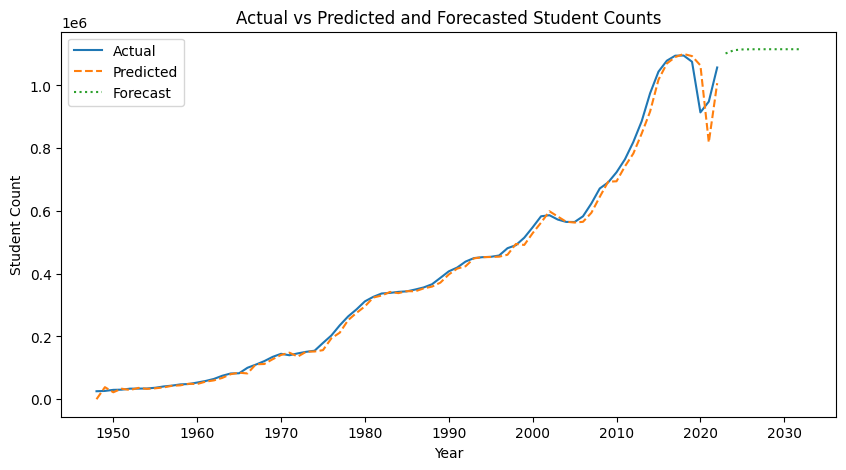

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
import re

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load the data
academic = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/academic.csv')
source_of_fund = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/source_of_fund.csv')
status = pd.read_csv('/Users/seemanthrajukurapati/Desktop/admin/archive (1)/status.csv')

# Clean the 'year' column by extracting the start year from entries like "1948/49"
academic['year'] = academic['year'].astype(str).apply(lambda x: re.match(r'^\d{4}', x).group(0) if re.match(r'^\d{4}', x) else x)

# Convert 'year' column to datetime format
academic['year'] = pd.to_datetime(academic['year'] + '-01-01', format='%Y-%m-%d')

# Group data by year and sum the student counts
student_data = academic.groupby('year')['students'].sum().reset_index()
student_data.set_index('year', inplace=True)
student_data = student_data.asfreq('AS')  # Annual frequency starting in January

# Fit an ARIMA model to the student data
arima_model = ARIMA(student_data['students'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Generate predictions and align index with the actual data
train_pred = arima_result.predict(start=student_data.index[0], end=student_data.index[-1])
train_pred.index = student_data.index  # Aligning predicted index to match the actual data

# Calculate performance metrics
if len(train_pred) == len(student_data['students']):
    print("Mean Absolute Error:", mean_absolute_error(student_data['students'], train_pred))
    print("R2 Score:", r2_score(student_data['students'], train_pred))
else:
    print("Mismatch in prediction and actual data lengths.")

# Save forecast results, if needed
forecast = arima_result.get_forecast(steps=10)  # Forecast 10 years into the future
forecast_index = pd.date_range(student_data.index[-1] + pd.offsets.YearBegin(), periods=10, freq='AS')
forecast_data = forecast.predicted_mean
forecast_data.index = forecast_index
print("Forecasted data:\n", forecast_data)

# Optional: Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(student_data.index, student_data['students'], label='Actual')
plt.plot(train_pred.index, train_pred, label='Predicted', linestyle='--')
plt.plot(forecast_data.index, forecast_data, label='Forecast', linestyle=':')
plt.xlabel('Year')
plt.ylabel('Student Count')
plt.title('Actual vs Predicted and Forecasted Student Counts')
plt.legend()
plt.show()


# Regression model 

Training MAE: 36555.241291928294
Testing MAE: 30576.371487021446
Training R2 Score: 0.9718164351710479
Testing R2 Score: 0.9781310866176934


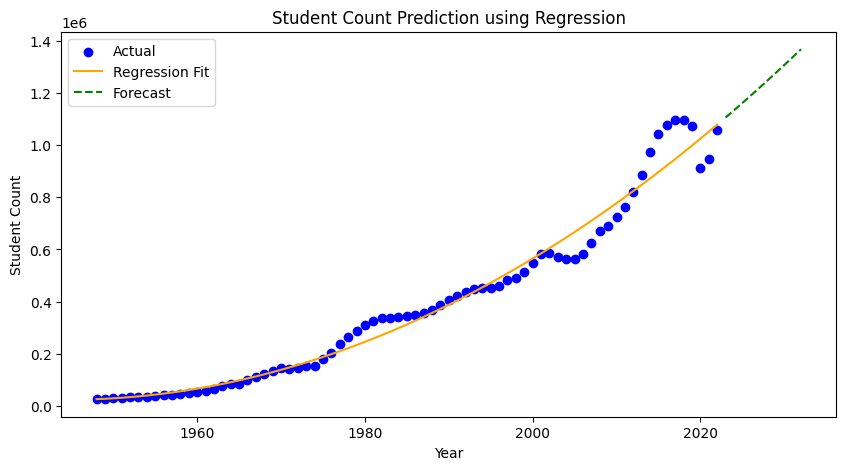

   Year  Predicted Students
0  2023        1.106101e+06
1  2024        1.133826e+06
2  2025        1.161901e+06
3  2026        1.190326e+06
4  2027        1.219102e+06
5  2028        1.248229e+06
6  2029        1.277706e+06
7  2030        1.307533e+06
8  2031        1.337712e+06
9  2032        1.368240e+06


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Prepare the data
student_data = academic.groupby('year')['students'].sum().reset_index()
student_data['year_num'] = student_data['year'].dt.year  # Extract numeric year for regression

# Features and target
X = student_data[['year_num']]
y = student_data['students']

# Polynomial features (e.g., quadratic trend)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate model performance
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Testing MAE:", mean_absolute_error(y_test, y_test_pred))
print("Training R2 Score:", r2_score(y_train, y_train_pred))
print("Testing R2 Score:", r2_score(y_test, y_test_pred))

# Predict future student counts
future_years = np.arange(student_data['year_num'].max() + 1, student_data['year_num'].max() + 11).reshape(-1, 1)
future_years_poly = poly.transform(future_years)
future_predictions = model.predict(future_years_poly)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(student_data['year_num'], y, label='Actual', color='blue')
plt.plot(student_data['year_num'], model.predict(X_poly), label='Regression Fit', color='orange')
plt.plot(future_years, future_predictions, label='Forecast', linestyle='--', color='green')
plt.xlabel('Year')
plt.ylabel('Student Count')
plt.title('Student Count Prediction using Regression')
plt.legend()
plt.show()

# Print forecast results
forecast_df = pd.DataFrame({'Year': future_years.flatten(), 'Predicted Students': future_predictions})
print(forecast_df)


# Comparison of the number of US students and international students

In [ ]:
fig1a = go.Figure()
fig1a.add_trace(go.Scatter(x=academic["year"], y=academic["us_students"],
                    mode='lines',
                    name='us students'))
fig1a.add_trace(go.Scatter(x=academic["year"], y=academic["students"],
                    mode='lines',
                    name='international students'))
fig1a.update_layout(title='Comparison of the number of students',
                    xaxis_title='Year',
                    yaxis_title='N° of students')
fig1a.show()

# How much has the number of international students in the United States grown over time?

In [ ]:
fig1b = go.Figure()

fig1b.add_trace(go.Scatter(x=academic["year"], y=academic["students"],
                    mode='lines',
                    name='international students'))


fig1b.update_layout(title='How much has the number of international students in the United States grown over time?',
                    xaxis_title='Year',
                    yaxis_title='Percentage')
fig1b.show()

# How has the distribution of academic types among students changed over time?

In [ ]:
academic_detail["year"] = academic_detail['year'].str[:4].astype(int)
ad1 = academic_detail[["year", "academic_type", "students"]]
adg1 = ad1.groupby(['year', 'academic_type']).sum()
adg1 = adg1.reset_index()

fig2a = go.Figure()

for academic_type in adg1['academic_type'].unique():
    subset = adg1[adg1['academic_type'] == academic_type]
    fig2a.add_trace(go.Scatter(x=subset['year'], y=subset['students'],
                               mode='lines',
                               name=academic_type,
                               line=dict(width=2)))

fig2a.update_traces(fill='tozeroy', line=dict(width=0))

sorted_traces = sorted(fig2a.data, key=lambda x: sum(x.y), reverse=True)
fig2a.data = sorted_traces

fig2a.update_layout(title='Comparison of the number of students',
                    xaxis_title='Year', yaxis_title='Number of Students', showlegend=True)

fig2a.show()

In [ ]:
adg1['percentage_students'] = adg1.groupby('year')['students'].transform(lambda x: x / x.sum() * 100)

fig2b = go.Figure()

for academic_type in adg1['academic_type'].unique():
    subset = adg1[adg1['academic_type'] == academic_type]
    fig2b.add_trace(go.Scatter(x=subset['year'], y=subset['percentage_students'],
                               mode='lines',
                               name=academic_type,
                               line=dict(width=2)))

fig2b.update_layout(xaxis_title='Year', yaxis_title='Percentage of Students',
                    title='Percentage of Students by Academic Type over time',
                    showlegend=True)

fig2b.show()

# How has the academic level been distributed across academic types over time?

In [ ]:
fig2b = px.bar(academic_detail, x='year', y='students', color='academic_level',
             facet_col='academic_type', facet_col_wrap=1,
             labels={'students': 'Number of Students'},
             height=1000)

# Aggiorna il layout per migliorare la visualizzazione
fig2b.update_layout(xaxis_title='Year', yaxis_title='Number of Students')

# Mostra il grafico
fig2b.show()

# How has the distribution of field of study among students changed over time?

In [ ]:
field_of_study["year"] = field_of_study['year'].str[:4].astype(int)
fos1 = field_of_study[["year", "field_of_study", "students"]]
fosg1 = fos1.groupby(['year', 'field_of_study']).sum()
fosg1 = fosg1.reset_index()

fig3a = go.Figure()

for field_of_study in fosg1['field_of_study'].unique():
    subset = fosg1[fosg1['field_of_study'] == field_of_study]
    fig3a.add_trace(go.Scatter(x=subset['year'], y=subset['students'],
                               mode='lines',
                               name=field_of_study,
                               line=dict(width=2)))

fig3a.update_traces(fill='tozeroy', line=dict(width=0))

sorted_traces = sorted(fig3a.data, key=lambda x: sum(x.y), reverse=True)
fig3a.data = sorted_traces

fig3a.update_layout(title='Comparison of the number of students',
                    xaxis_title='Year', yaxis_title='Number of Students', showlegend=True)

fig3a.show()

In [ ]:
fosg1['percentage_students'] = fosg1.groupby('year')['students'].transform(lambda x: x / x.sum() * 100)

fig3b = go.Figure()

for field_of_study in fosg1['field_of_study'].unique():
    subset = fosg1[fosg1['field_of_study'] == field_of_study]
    fig3b.add_trace(go.Scatter(x=subset['year'], y=subset['percentage_students'],
                               mode='lines',
                               name=field_of_study,
                               line=dict(width=2)))

fig3b.update_layout(xaxis_title='Year', yaxis_title='Percentage of Students',
                    title='Percentage of Students by Academic Type over time',
                    showlegend=True)

fig3b.show()

In [ ]:
origin["year"] = origin['year'].str[:4].astype(int)
origin.head()

,year,origin_region,origin,academic_type,students
0,2000,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Graduate,2
1,2000,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Other,0
2,2000,"Africa, Subsaharan","Africa, Subsaharan, Unspecified",Undergraduate,6
3,2000,Asia,"Asia, Unspecified",Graduate,0
4,2000,Asia,"Asia, Unspecified",Other,6


# Which continent do most international students studying in the United States come from?

In [ ]:
europe_list = ["Europe"]
africa_list = ["West_Africa", "Southern Africa", "East Africa", "Central Africa", "North Africa", "Africa, Subsaharan"]
america_list = ["Caribbean", "South America", "Mexico and Central America", "Latin America and Caribbean", "North America"]
oceania_list = ["Oceania", "Stateless"]
asia_list = ["Middle East", "South and Central Asia", "Southeast Asia", "East Asia", "Asia"]

region_lists = {
    "Europe": europe_list,
    "Africa": africa_list,
    "America": america_list,
    "Oceania": oceania_list,
    "Asia": asia_list
}

origin['continent'] = origin['origin_region'].apply(lambda x: next((key for key, value in region_lists.items() if x in value), x))

sum_df = origin.groupby('continent')['students'].sum().reset_index()

sum_df = sum_df.sort_values(by='students', ascending=False)

colors = [f'rgb({i}, 0, 0)' for i in range(0, 256, int(256/len(sum_df)))][::-1]


# Creare il barplot con Plotly
fig3a = go.Figure()
fig3a.add_trace(go.Bar(
    x=sum_df['continent'],
    y=sum_df['students'],
    marker=dict(color=colors),
    hoverinfo='y+text',
    text=sum_df['students']
))

fig3a.update_layout(
    xaxis_title='Continent',
    yaxis_title='Number of students'
)

fig3a.show()

# For each continent, which are the states whose students are most present in the United States?

In [ ]:
sum_df = origin.groupby(['origin_region', 'origin'])['students'].sum().reset_index()

fig = sp.make_subplots(rows=len(region_lists), cols=1, subplot_titles=list(region_lists.keys()))

for i, (category, countries) in enumerate(region_lists.items(), 1):
    top_10_df = sum_df[sum_df['origin_region'].isin(countries)].nlargest(10, 'students')
    bar_trace = go.Bar(
        x=top_10_df['origin'],
        y=top_10_df['students'],
        name=category
    )
    fig.add_trace(bar_trace, row=i, col=1)
    if i == 1:
        fig.update_yaxes(title_text='Number of students', row=i, col=1)
    if i == len(region_lists):
        fig.update_xaxes(title_text='Countries', row=i, col=1)

fig.update_layout(height=len(region_lists) * 300)

fig.show()

# Which academic types are most frequent among students from various continents?

In [ ]:
sum_df_academic = origin.groupby(['continent', 'academic_type'])['students'].sum().reset_index()

# Ordinare il dataframe in modo decrescente in base al numero di studenti
sum_df_academic = sum_df_academic.sort_values(by='students', ascending=False)

# Creare una figura con subplot per ogni continente
fig_academic = sp.make_subplots(rows=len(origin['continent'].unique()), cols=1, subplot_titles=origin['continent'].unique())

# Creare i barplot ordinati per ogni continente
for i, continent in enumerate(origin['continent'].unique(), 1):
    data = sum_df_academic[sum_df_academic['continent'] == continent]
    bar_trace = go.Bar(
        x=data['academic_type'],
        y=data['students'],
        name=continent
    )
    fig_academic.add_trace(bar_trace, row=i, col=1)

    # Aggiungere etichette agli assi per il primo subplot
    if i == 1:
        fig_academic.update_yaxes(title_text='Numero di studenti', row=i, col=1)
    # Aggiungere etichette agli assi per l'ultimo subplot
    if i == len(origin['continent'].unique()):
        fig_academic.update_xaxes(title_text='Academic Type', row=i, col=1)

# Aggiornare il layout della figura
fig_academic.update_layout(height=len(origin['continent'].unique()) * 300)

fig_academic.show()